Data pre-processing for the ML for genetic data notebook.

* Genotype and phenotype data were downloaded as PLINK files from [Easy GWAS](https://easygwas.ethz.ch/data/public/dataset/view/1/)
* Protein-protein interaction data was downloaded from [TAIR](https://www.arabidopsis.org/download/index-auto.jsp?dir=%2Fdownload_files%2FProteins%2FProtein_interaction_data)
* Gene positions were downloaded from [TAIR](https://www.arabidopsis.org/download/index-auto.jsp?dir=%2Fdownload_files%2FGenes%2FTAIR9_genome_release%2Ftair9_gff3) 

The genome build is TAIR9.

## Cleaning genotype data
* Converted PLINK genotypes to a 0/1 encoding

```
   plink --file genotype --recode A --out arabidopsis
```

* Common pre-processing step in Arabidopsis GWAS studies: remove SNPS with a minor allele frequency of less than 10%

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Only use SNPs in/near candidate genes

In [3]:
# Names of all SNPs in the data
with open('data/athaliana.raw') as f:
    header = f.readline()
    snp_names = header.split()[6:]
    f.close()
print(len(snp_names), snp_names[:10])

214051 ['Chr1_657_T', 'Chr1_3102_G', 'Chr1_4648_A', 'Chr1_4880_T', 'Chr1_5975_G', 'Chr1_6063_T', 'Chr1_6449_C', 'Chr1_6514_C', 'Chr1_6603_C', 'Chr1_6768_G']


In [5]:
# List of candidate genes
import h5py
f = h5py.File('data/arabidopsis_processed_data/FT_cand_genes.hd5', 'r')
candidate_genes = set(f['gene_id'])
print(len(candidate_genes), list(candidate_genes)[:10])

165 [b'AT1G43700', b'AT3G33520', b'AT1G61040', b'AT2G28290', b'AT5G61150', b'AT5G62430', b'AT3G62090', b'AT1G55080', b'AT4G32980', b'AT3G10390']


In [14]:
# Candidate genes positions (not trusting those in the hd5 file to be in the TAIR9 build)
chromosomes = {}
window = 20000

with open('data/TAIR9_GFF3_genes.gff') as f:
    for line in f:
        ls = line.split()
        if ls[2] == 'protein':
            if ls[0] in ['ChrC', 'ChrM']:
                continue
            ccc = int(ls[0][3])
            beg = int(ls[3])
            end = int(ls[4])
            protein_name = ls[8].split(".")[0][3:]
            if protein_name in candidate_genes:
                if not chromosomes.has_key(ccc):
                    chromosomes[ccc] = {}
                chromosomes[ccc][(beg-window)] = [(end+window), protein_name]
    f.close()

In [15]:
chromosomes

{}

In [11]:
print(len(chromosomes), len(chromosomes[1]))
print(chromosomes[1].keys()[:10])
print(chromosomes[1][chromosomes[1].keys()[0]])

KeyError: 1

In [8]:
# Sort candidate gene positions (for easier search)
sorted_begins = []
chromosomes_ids = chromosomes.keys()
chromosomes_ids.sort()
print(chromosomes_ids)
for ccc in chromosomes_ids:
    begins = chromosomes[ccc].keys()
    begins.sort()
    print(ccc, len(begins))
    sorted_begins.append(begins)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(chromosomes_ids)? (<ipython-input-8-14b9d4db1b1f>, line 5)

In [9]:
cand_snps = [] # list of indices (in snp_names) of SNPs in/near candidate genes
snps_in_genes = {} # key = SNP name, value = [index (in snp_names), set of proteins]
snps_by_genes = {} # key = protein name, value = list of SNP names.

for snp_idx, snp in enumerate(snp_names):
    ccc = int(snp[3])
    pos = int(snp.split("_")[1])
    begins = sorted_begins[(ccc-1)]
    
    # list all possible begin positions (those that are before pos)
    possible_begs = []
    for beg in begins:
        if beg <= pos:
            possible_begs.append(beg)
        else:
            break 
            
    proteins = set([])
    # reverse the list of possible begin positions
    possible_begs.reverse()
    for beg in possible_begs:
        # look for end positions that are after pos
        end, protein_name = chromosomes[ccc][beg]
        if end >= pos:
            if not snps_in_genes.has_key(snp):
                snps_in_genes[snp] = [snp_idx]
            proteins.add(protein_name)
        else:
            # now both begin and end are before pos, stop looking
            break
                
    if snps_in_genes.has_key(snp):
        # this SNP is in/near a candidate gene, keep processing
        snps_in_genes[snp].append(proteins)
        for protein_name in proteins:
            if not snps_by_genes.has_key(protein_name):
                snps_by_genes[protein_name] = []
            snps_by_genes[protein_name].append(snp)
                
        cand_snps.append(snp_idx)

NameError: name 'sorted_begins' is not defined

In [10]:
print(len(cand_snps), cand_snps[:10])
print(len(snps_in_genes), snps_in_genes.keys()[:10])
print(snps_in_genes[snps_in_genes.keys()[0]])
print(len(snps_by_genes), snps_by_genes.keys()[:10])
print(snps_by_genes[snps_by_genes.keys()[0]])

0 []


TypeError: 'dict_keys' object is not subscriptable

In [ ]:
cand_snps.sort()
print(len(set(cand_snps)))

### Filter by minor allele frequency

In [ ]:
# Count minor allele frequency
with open('data/athaliana.raw') as f:
    header = f.readline()
    snps_ids = header.split()[6:]
    snps_freq_dict = {} # key: snp name, value: number of individuals with this SNP's minor allele
    num_samples = 0
    # initialize snp counts
    for idx in cand_snps:
        snps_freq_dict[idx] = 0
    # count minor alleles
    for line in f:
        num_samples += 1
        ls = line.split()[6:]
        for snp_idx in cand_snps:
            if int(ls[snp_idx]):
                snps_freq_dict[snp_idx] += 1
    f.close()   

In [ ]:
print(num_samples)
print(len(snps_freq_dict), snps_freq_dict.keys()[:10])
print(snps_freq_dict[snps_freq_dict.keys()[20]])

In [ ]:
# maf threshold = 10%
threshold = 0.1 * float(num_samples)

keep_snp_names = [] 
keep_snp_indices = []

for snp_idx, snp_id in enumerate(snp_names):
    if snps_freq_dict.has_key(snp_idx):
        if snps_freq_dict[snp_idx] > threshold:
            # keep SNP
            keep_snp_names.append(snp_id)
            keep_snp_indices.append(snp_idx)
            
print(len(keep_snp_indices), keep_snp_indices[:10], keep_snp_names[:10])

### Save data

In [ ]:
with open('data/athaliana_small.snps.txt', 'w') as f:
    f.write("%s\n" % " ".join(keep_snp_names))
    f.close()

In [ ]:
samples = []
with open('data/athaliana.raw') as f:
    f.readline() # header
    with open('data/athaliana_small.X.txt', 'w') as g:
        for line in f:
            samples.append(line.split()[0])
            snps = np.array(line.split()[6:])
            # only keep SNPs with index in keep_snp_indices
            # and convert "2" into "1"
            g.write("%s\n" % str.replace(" ".join(snps[keep_snp_indices]), '2', '1'))
    f.close()
    g.close()

In [ ]:
with open('data/athaliana.samples.txt', 'w') as g:
    g.write(" ".join(samples))
    g.write("\n")

### Load data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names), snp_names[:10])

9419 ['Chr1_21043_T', 'Chr1_21128_T', 'Chr1_21829_C', 'Chr1_22522_G', 'Chr1_27265_C', 'Chr1_29291_A', 'Chr1_31515_G', 'Chr1_32807_A', 'Chr1_35856_C', 'Chr1_37072_G']


In [3]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers
print(len(samples), samples[:10])

1307 [9381, 9380, 9378, 9371, 9367, 9363, 9356, 9355, 9354, 9353]


In [4]:
# Load the design matrix 
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype='int') # values are integers

In [5]:
n, p = X.shape

## Building the network
* Create a sparse matrix.
* Create edges between all neighboring SNPs (in the genetic sequence), with a weight of 0.01.
* Create edges between all pairs of SNPs that are in the same gene.
* Create edges between all pairs of SNPs that are in two interacting genes.

In [6]:
from scipy import sparse

In [ ]:
p = len(keep_snp_indices)
print(p)
W = sparse.lil_matrix(sparse.eye(p, k=1)*0.01) # connect each SNP to the next one

In [ ]:
# Get SNP index in X from its name
snp_index = {}
for snp_idx, snp_name in enumerate(keep_snp_names):
    snp_index[snp_name] = snp_idx
print(len(snp_index), snp_index.keys()[:10], snp_index[snp_index.keys()[0]])

In [ ]:
# Gene membership
for snp_list in snps_by_genes.values():
    if not len(snp_list):
        break
    for ix1, snp1 in enumerate(snp_list):
        if snp_index.has_key(snp1):
            # We kept that SNP
            for snp2 in snp_list[ix1+1:]:
                if snp_index.has_key(snp2):
                    W[snp_index[snp1], snp_index[snp2]] = 1.
                    W[snp_index[snp2], snp_index[snp1]] = 1.

In [ ]:
W

In [ ]:
# Protein-protein interactions
ppi_set = set([])
with open('data/TairProteinInteraction.20090527.txt') as f:
    f.readline() # header
    for line in f:
        ls = line.split()
        if ls[0] < ls[2]:
            ppi = (ls[0], ls[2])
        else:
            ppi = (ls[2], ls[0])
        ppi_set.add(ppi)
print(len(ppi_set))

In [ ]:
for ppi in ppi_set:
    if snps_by_genes.has_key(ppi[0]):
        for snp1 in snps_by_genes[ppi[0]]:        
            if snp_index.has_key(snp1):
                if snps_by_genes.has_key(ppi[1]):
                    for snp2 in snps_by_genes[ppi[1]]:
                        if snp_index.has_key(snp2):
                            W[snp_index[snp1], snp_index[snp2]] = 1.
                            W[snp_index[snp2], snp_index[snp1]] = 1.

In [ ]:
W

In [ ]:
1291643./(9419*9419)

In [ ]:
W = sparse.coo_matrix(W)

In [ ]:
A = np.array([W.row, W.col, W.data])
np.savetxt('data/athaliana_small.W.txt', A)

### Load the network

In [6]:
from scipy import sparse

In [7]:
w_saved = np.loadtxt('data/athaliana_small.W.txt')

In [8]:
W = sparse.coo_matrix((w_saved[2, :], (np.array(w_saved[0, :], dtype=int), 
                                       np.array(w_saved[1, :], dtype=int))), shape=(p, p))

### Check incidence matrix can be built

In [9]:
# Compute node degrees 
degrees = np.zeros((p, ))
for vertex in W.row:
    degrees[vertex] += 2

In [10]:
tim = sparse.lil_matrix((W.row.shape[0], p))
for ix, edge in enumerate(W.data):
    tim[ix, W.row[ix]] = np.sqrt(edge / degrees[W.row[ix]])
    tim[ix, W.col[ix]] = - np.sqrt(edge / degrees[W.col[ix]])

### Check ncLasso runs

In [11]:
del W, degrees

In [12]:
import pandas as pd

TODO CHANGE

In [13]:
df = pd.read_csv('data/old/athaliana.2W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True) # columns are separated by white space

# Create vector of sample IDs
samples_with_phenotype = list(df[0])
print(len(samples_with_phenotype), "samples have a phenotype")

# Create vector of phenotypes
y_2W = np.array(df[1])

152 samples have a phenotype


In [14]:
print(len(samples_with_phenotype), samples_with_phenotype[:10])

152 [5837, 6008, 6009, 6016, 6040, 6042, 6043, 6064, 6074, 6243]


In [15]:
# Restrict X to the samples with a 2W phenotype, in correct order
# X_2W[i] = X[samples.index(samples_with_phenotype[i])]
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype]), :]
n, p = X_2W.shape
print(n, p)

152 9419


In [16]:
# You can delete X now to free space
del X

In [17]:
from sklearn import base, linear_model

In [18]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, transposed_incidence=None, lambda1=1.0, lambda2=1.0):
        self.transposed_incidence = transposed_incidence # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
        alpha = self.lambda1/(np.sqrt(self.lambda2+1.))
        self.lasso = linear_model.Lasso(fit_intercept=True, alpha=alpha)
        
        
    def fit(self, X, y):
        print(self.lambda1)
        print(self.lambda2)
        
        y_new = np.hstack((y, np.zeros((self.transposed_incidence.shape[0], ))))
        print(y_new.shape, X.shape)
        X_new = 1/(np.sqrt(self.lambda2+1)) * sparse.vstack((X, np.sqrt(self.lambda2)*\
                                                    self.transposed_incidence))
        
        
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_[:X.shape[1]]/(np.sqrt(self.lambda2+1))
        
        
    def predict(self, X, y=None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y=None):
        return self.lasso.score(X, y)                                        

In [19]:
from sklearn import model_selection

In [20]:
l1 = [0.001]# np.logspace(-3., 2., num=6)
l2 = [0.1] #np.logspace(0., 2., num=3)

In [21]:
nclasso = ncLasso(transposed_incidence=tim)
print nclasso

ncLasso(lambda1=1.0, lambda2=1.0,
    transposed_incidence=<1291643x9419 sparse matrix of type '<type 'numpy.float64'>'
	with 2582679 stored elements in LInked List format>)


In [22]:
model_nc = model_selection.GridSearchCV(nclasso, param_grid={'lambda1': l1, 
                                                             'lambda2': l2}, 
                                        scoring='explained_variance')
model_nc.fit(X_2W, y_2W)

0.001
0.1
(1291744,) (101, 9419)


TypeError: predict() takes exactly 2 arguments (3 given)

(0, 9419)

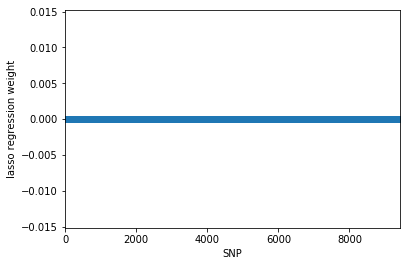

In [34]:
plt.figure(figsize=(6, 4))
plt.scatter(range(p), # x = SNP position
            model_nc.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("lasso regression weight")
plt.xlim([0, p])

# Old

In [1]:
print("hello")

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("hello")? (<ipython-input-1-2a0eaa89f43f>, line 1)

In [ ]:
# Count minor allele frequency
with open('data/athaliana.raw') as f:
    header = f.readline()
    snps_ids = header.split(" ")[6:]
    snps_freq_dict = {} # key: snp name, value: number of individuals with this SNP's minor allele
    num_samples = 0
    for idx in range(len(snps_ids)):
        snps_freq_dict[idx] = 0
    for line in f:
        num_samples += 1
        for idx, snp in enumerate(line.split(" ")[6:]):
            if int(snp):
                snps_freq_dict[idx] += 1
    f.close()        

In [ ]:
# maf threshold = 10%
threshold = 0.1 * float(num_samples)
    
new_header = []
snps_pass_maf_idx = []
for idx in range(len(snps_ids)):
    if snps_freq_dict[idx] > threshold:
        # keep SNP
        new_header.append(snps_ids[idx])
        snps_pass_maf_idx.append(idx)
        
print(len(new_header))

In [ ]:
with open('data/athaliana.snps.txt', 'w') as g:
    g.write(" ".join(new_header))
    g.write("\n")

### Feature selection
* Map SNPS to genes using a 20kbp window.
* For the purpose of this lab, we want to be able to run all methods quickly. We selected 20 000 SNPs at random among those that are mapped to genes.


In [ ]:
with open('data/athaliana.snps.txt') as f:
    snps_pass_maf = f.readline().split()
    f.close()

In [ ]:
print len(snps_pass_maf)

In [ ]:
chromosomes = {}
window = 20000
with open('data/TAIR9_GFF3_genes.gff') as f:
    for line in f:
        ls = line.split()
        if ls[2] == 'protein':
            if ls[0] in ['ChrC', 'ChrM']:
                continue
            ccc = int(ls[0][3])
            beg = int(ls[3])
            end = int(ls[4])
            protein_name = ls[8].split(".")[0][3:]
            if not chromosomes.has_key(ccc):
                chromosomes[ccc] = {}
            chromosomes[ccc][(beg-window)] = [(end+window), protein_name]
    f.close()

In [ ]:
sorted_begins = []
chromosomes_ids = chromosomes.keys()
chromosomes_ids.sort()
print(chromosomes_ids)
for ccc in chromosomes_ids:
    begins = chromosomes[ccc].keys()
    begins.sort()
    print ccc, len(begins)
    sorted_begins.append(begins)

In [ ]:
import h5py
f = h5py.File('data/arabidopsis_processed_data/FT_cand_genes.hd5', 'r')
candidate_genes = set(f['gene_id'])

In [ ]:
cand_snps = [] # list of indices (in snps_pass_maf) of candidate SNPs
gene_snps = [] # list of indices (in snps_pass_maf) of SNPs in/near genes
snps_in_genes = {} # key = SNP name, value = [index (in snps_pass_maf), set of proteins]
snps_by_genes = {} # key = protein name, value = list of SNP names.


for idx_in_snps_pass_maf, snp in enumerate(snps_pass_maf):
    ccc = int(snp[3])
    pos = int(snp.split("_")[1])
    begins = sorted_begins[(ccc-1)]
    
    # list all possible begin positions (those that are before pos)
    possible_begs = []
    for beg in begins:
        if beg <= pos:
            possible_begs.append(beg)
        else:
            break 
            
    proteins = set([])
    # reverse the list of possible begin positions
    possible_begs.reverse()
    for beg in possible_begs:
        # look for end positions that are after pos
        end, protein_name = chromosomes[ccc][beg]
        if end >= pos:
            if not snps_in_genes.has_key(snp):
                snps_in_genes[snp] = [idx_in_snps_pass_maf]
            proteins.add(protein_name)
        else:
            # now both begin and end are before pos, stop looking
            break
                
    if snps_in_genes.has_key(snp):
        # this is not an intergenic gene, keep processing
        snps_in_genes[snp].append(proteins)
        for protein_name in proteins:
            if not snps_by_genes.has_key(protein_name):
                snps_by_genes[protein_name] = []
            snps_by_genes[protein_name].append(snp)
                
        if len(proteins.intersection(candidate_genes)):
            cand_snps.append(idx_in_snps_pass_maf)
        else:
            gene_snps.append(idx_in_snps_pass_maf)

In [ ]:
print(len(cand_snps), len(gene_snps))

In [ ]:
print(snps_pass_maf[:10], len(snps_pass_maf))

In [ ]:
# indices in snps_pass_maf of the SNPs that we are keeping
now_keeping = [idx for idx in cand_snps]
import random
random.shuffle(gene_snps)
now_keeping.extend(gene_snps[:10000])
now_keeping.sort()

# indices in the original SNP list of the SNPs that we are keeping
with open('data/athaliana.raw') as f:
    all_snps = f.readline().split()[6:]
    f.close()
    
now_keeping_indices = []
for idx in now_keeping:
    now_keeping_indices.append(all_snps.index(snps_pass_maf[idx]))
    
now_keeping_indices.sort()

In [ ]:
now_keeping_indices.sort()

In [ ]:
with open('data/athaliana_small.snps.txt', 'w') as f:
    f.write("%s\n" % " ".join([all_snps[idx] for idx in now_keeping_indices]))
    f.close()

In [ ]:
samples = []
with open('data/athaliana.raw') as f:
    f.readline() # header
    with open('data/athaliana_small.X.txt', 'w') as g:
        for line in f:
            samples.append(line.split()[0])
            snps = np.array(line.split()[6:])
            g.write("%s\n" % str.replace(" ".join(snps[now_keeping_indices]), '2', '1'))
    f.close()
    g.close()

In [ ]:
with open('data/athaliana.samples.txt', 'w') as g:
    g.write(" ".join(samples))
    g.write("\n")

### Cleaning phenotype data
* For each of the phenotypes, regress out the 4 first principal components of the genetic data. This is a common pre-processing step to remove population structure effects.

#### For 2W

In [ ]:
# I need the index in X, that is to say in samples, of the samples in 2W.pheno
rows_2W = []
y = []
samples_2W = []
with open('data/2W.pheno') as f:
    f.readline() # header
    for line in f:
        sample_id = line.split()[1]
        rows_2W.append(samples.index(sample_id))
        y.append(float(line.split()[2]))
    f.close()
y = np.array(y)

In [ ]:
X = np.loadtxt('data/athaliana_small.X.txt', dtype='int')
X = X[rows_2W, :]
print(X.shape)

Check genomic inflation -- is there population structure?

We compute p-values for the phenotype and check whether the distribution matches a uniform distribution. If not, it is likely due to confounding by population structure. We regress out PCs of the genotype data until the distribution is uniform.

In [ ]:
import statsmodels.api as sm

In [ ]:
pvalues = []
for feat_idx in range(X.shape[1]):
    myX = X[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

In [ ]:
%pylab inline

In [ ]:
# QQ plot
import scipy.stats as ss
ss.probplot(pvalues, dist="uniform", plot=plt)
plt.show(block=False)

Regress out principal components

In [ ]:
from sklearn import decomposition, linear_model

In [ ]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)

In [ ]:
X_proj = X.dot(pca.components_.T)

model = linear_model.LinearRegression()
model.fit(X_proj, y)
y_pred = model.predict(X_proj)
y_res = y - y_pred

In [ ]:
pvalues = []
for feat_idx in range(X.shape[1]):
    myX = X[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_res, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

# QQ plot
import scipy.stats as ss
ss.probplot(pvalues, dist="uniform", plot=plt)
plt.show(block=False)

In [ ]:
with open('data/athaliana.2W.pheno', 'w') as f:
    for ix, sample_id in enumerate([samples[ixx] for ixx in rows_2W]):
        f.write('%s %.2f\n' % (sample_id, y_res[ix]))
    f.close()

#### For 4W

In [ ]:
# I need the index in X, that is to say in samples, of the samples in 2W.pheno
rows_4W = []
y = []
samples_4W = []
with open('data/4W.pheno') as f:
    f.readline() # header
    for line in f:
        sample_id = line.split()[1]
        rows_4W.append(samples.index(sample_id))
        y.append(float(line.split()[2]))
    f.close()
y = np.array(y)

In [ ]:
X = np.loadtxt('data/athaliana_small.X.txt', dtype='int')
X = X[rows_4W, :]
print(X.shape)

In [ ]:
pvalues = []
for feat_idx in range(X.shape[1]):
    myX = X[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

In [ ]:
# QQ plot
import scipy.stats as ss
ss.probplot(pvalues, dist="uniform", plot=plt)
plt.show(block=False)

Regress out principal components

In [ ]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)

In [ ]:
X_proj = X.dot(pca.components_.T)

model = linear_model.LinearRegression()
model.fit(X_proj, y)
y_pred = model.predict(X_proj)
y_res = y - y_pred

In [ ]:
pvalues = []
for feat_idx in range(X.shape[1]):
    myX = X[:, feat_idx]
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_res, myX)
    est2 = est.fit()
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

# QQ plot
import scipy.stats as ss
ss.probplot(pvalues, dist="uniform", plot=plt)
plt.show(block=False)

In [ ]:
with open('data/athaliana.4W.pheno', 'w') as f:
    for ix, sample_id in enumerate([samples[ixx] for ixx in rows_4W]):
        f.write('%s %.2f\n' % (sample_id, y_res[ix]))
    f.close()

### Building the network
* Create a sparse matrix.
* Create edges between all neighboring SNPs (in the genetic sequence), with a weight of 0.01.
* Create edges between all pairs of SNPs that are in the same gene.
* Create edges between all pairs of SNPs that are in two interacting genes.



In [ ]:
from scipy import sparse

In [ ]:
# Create index of SNPs names in X
snp_index = {} # snp_name: snp_index
with open('data/athaliana_small.snps.txt') as f:
    snps = f.readline().split()
    f.close()

for snp_ix, snp_name in enumerate(snps):
    snp_index[snp_name] = snp_ix

In [ ]:
p = len(snps)
print(p)
W = sparse.lil_matrix(sparse.eye(p, k=1)*0.01) # connect each SNP to the next one

In [ ]:
# Gene membership
for snp_list in snps_by_genes.values():
    if len(snp_list) <= 1:
        break
    for ix1, snp1 in enumerate(snp_list):
        if snp_index.has_key(snp1):
            # We kept that SNP
            for snp2 in snp_list[ix1+1:]:
                if snp_index.has_key(snp2):
                    W[snp_index[snp1], snp_index[snp2]] = 1.
                    W[snp_index[snp2], snp_index[snp1]] = 1.

In [ ]:
W

In [ ]:
# Protein-protein interactions
ppi_set = set([])
with open('data/TairProteinInteraction.20090527.txt') as f:
    f.readline() # header
    for line in f:
        ls = line.split()
        if ls[0] < ls[2]:
            ppi = (ls[0], ls[2])
        else:
            ppi = (ls[2], ls[0])
        ppi_set.add(ppi)
print(len(ppi_set))

In [ ]:
for ppi in ppi_set:
    if snps_by_genes.has_key(ppi[0]):
        for snp1 in snps_by_genes[ppi[0]]:        
            if snp_index.has_key(snp1):
                if snps_by_genes.has_key(ppi[1]):
                    for snp2 in snps_by_genes[ppi[1]]:
                        if snp_index.has_key(snp2):
                            W[snp_index[snp1], snp_index[snp2]] = 1.
                            W[snp_index[snp2], snp_index[snp1]] = 1.

In [ ]:
W

In [ ]:
1087562./(19419*19419)

In [ ]:
W = sparse.coo_matrix(W)

In [ ]:
W.row

In [ ]:
A = np.array([W.row, W.col, W.data])
np.savetxt('data/athaliana_small.W.txt', A)

In [ ]:
www_ = np.loadtxt('data/athaliana_small.W.txt')

In [ ]:
W2 = sparse.coo_matrix((www_[2], (www_[0], www_[1])), shape=(p, p))

In [ ]:
W2

## Re-create SNP by gene list to save as file
Restricted to the SNPs included in the dataset.

In [ ]:
# Load the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

In [ ]:
chromosomes = {}
window = 20000
with open('data/TAIR9_GFF3_genes.gff') as f:
    for line in f:
        ls = line.split()
        if ls[2] == 'protein':
            if ls[0] in ['ChrC', 'ChrM']:
                continue
            ccc = int(ls[0][3])
            beg = int(ls[3])
            end = int(ls[4])
            protein_name = ls[8].split(".")[0][3:]
            if not chromosomes.has_key(ccc):
                chromosomes[ccc] = {}
            chromosomes[ccc][(beg-window)] = [(end+window), protein_name]
    f.close()

In [ ]:
sorted_begins = []
chromosomes_ids = chromosomes.keys()
chromosomes_ids.sort()
print chromosomes_ids
for ccc in chromosomes_ids:
    begins = chromosomes[ccc].keys()
    begins.sort()
    print ccc, len(begins)
    sorted_begins.append(begins)

In [ ]:
cand_snps = [] # list of indices (in snps_pass_maf) of candidate SNPs
gene_snps = [] # list of indices (in snps_pass_maf) of SNPs in/near genes
snps_in_genes = {} # key = SNP name, value = [index (in snps_pass_maf), set of proteins]
snps_by_genes = {} # key = protein name, value = list of SNP names.

for snp_idx, snp in enumerate(snp_names):
    ccc = int(snp[3])
    pos = int(snp.split("_")[1])
    begins = sorted_begins[(ccc-1)]
    
    # list all possible begin positions (those that are before pos)
    possible_begs = []
    for beg in begins:
        if beg <= pos:
            possible_begs.append(beg)
        else:
            break 
            
    proteins = set([])
    # reverse the list of possible begin positions
    possible_begs.reverse()
    for beg in possible_begs:
        # look for end positions that are after pos
        end, protein_name = chromosomes[ccc][beg]
        if end >= pos:
            if not snps_in_genes.has_key(snp):
                snps_in_genes[snp] = [snp_idx]
            proteins.add(protein_name)
        else:
            # now both begin and end are before pos, stop looking
            break
                
    if snps_in_genes.has_key(snp):
        # this is not an intergenic gene, keep processing
        snps_in_genes[snp].append(proteins)
        for protein_name in proteins:
            if not snps_by_genes.has_key(protein_name):
                snps_by_genes[protein_name] = []
            snps_by_genes[protein_name].append(snp)
                
        if len(proteins.intersection(candidate_genes)):
            cand_snps.append(snp_idx)
        else:
            gene_snps.append(snp_idx)            

In [ ]:
with open('data/athaliana.snps_by_gene.txt', 'w') as f:
    for gene, snps_list in snps_by_genes.iteritems():
        f.write("%s %s\n" % (gene, " ".join(snps_list)))
    f.close()

### List of candidate genes

In [ ]:
import h5py
f = h5py.File('data/arabidopsis_processed_data/FT_cand_genes.hd5', 'r')
candidate_genes = list(f['gene_id'])

In [ ]:
with open('data/athaliana.candidates.txt', 'w') as f:
    f.write("%s\n" % " ".join(candidate_genes))
    f.close